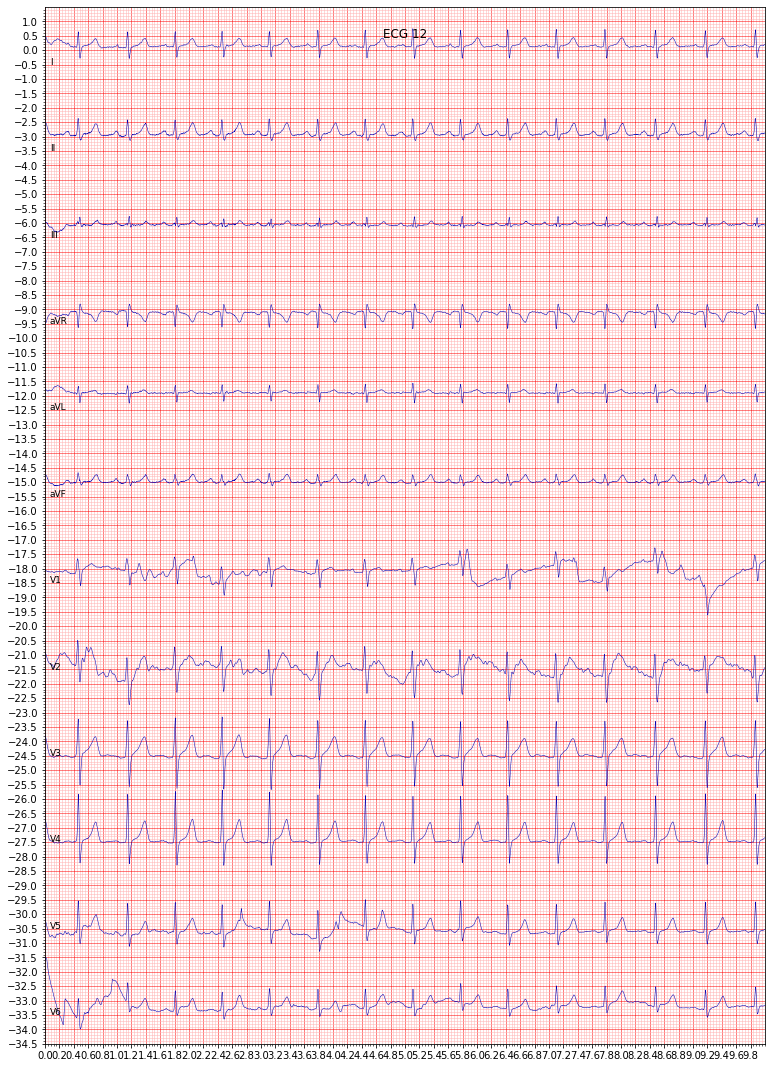

(12, 5000)


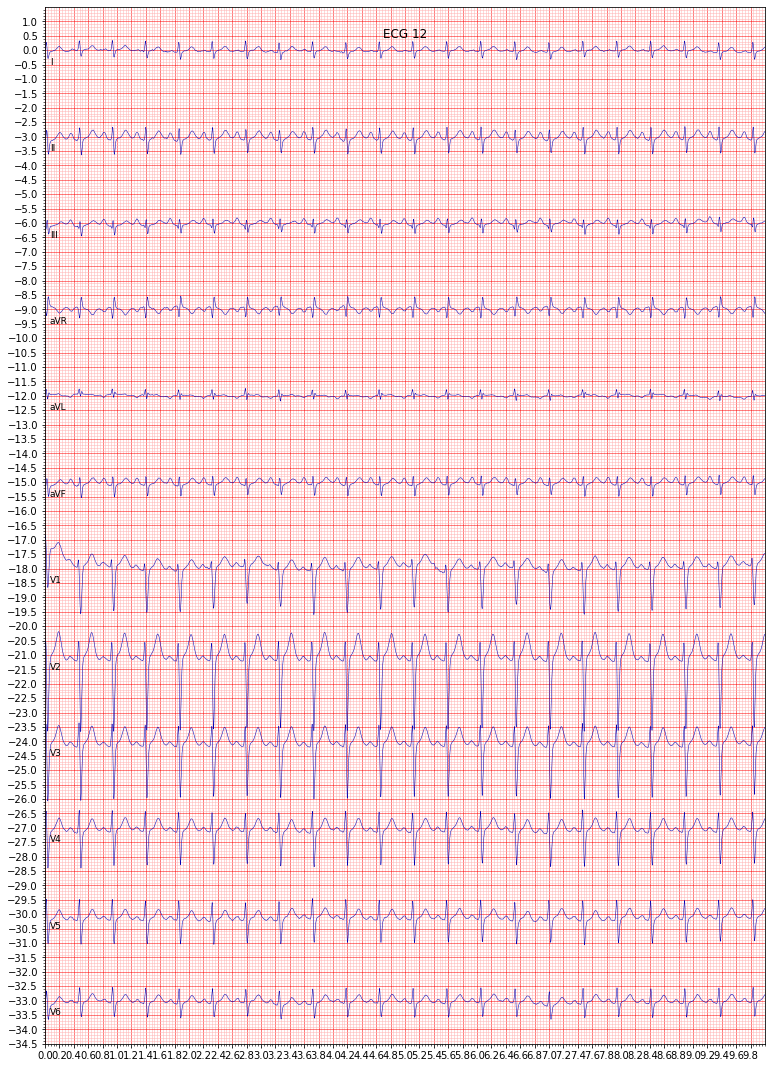

In [2]:
from scipy.io import loadmat
import ecg_plot
import pandas as pd

filename = "../data/train/TEST0004.mat"
image = loadmat(filename)
data_image = image["ecgdata"]
# data = pd.DataFrame(data_image)
# print(type(data_image))
# # print(data)
# mean_data = data.rolling(window=5).mean()

ecg_plot.plot(data_image, sample_rate = 500, title = 'ECG 12', columns=1)
ecg_plot.show()

filename = "../data/train/TEST0005.mat"
image = loadmat(filename)
data_image = image["ecgdata"]
print(data_image.shape)


ecg_plot.plot(data_image, sample_rate = 500, title = 'ECG 12', columns=1)
ecg_plot.show()

20


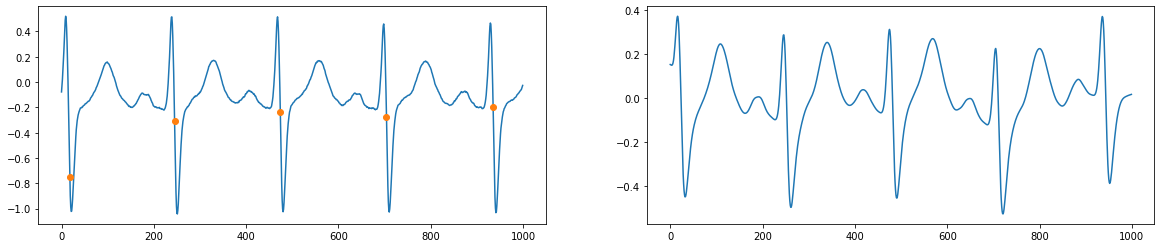

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import pandas as pd
from scipy import signal
import scipy
import peakutils

def range_regularization(data):
    if(np.min(data) < 0): data += abs(np.min(data))
    else: data -= abs(np.min(data))
    data /= np.max(data)

    return data

def linear_interpolation(data, outdim):

    inter_unit = outdim / data.shape[0]

    outdata = np.zeros((outdim, data.shape[1]))

    for sigidx in range(data.shape[0]):
        x1 = int((sigidx-1)*inter_unit)
        x2 = int((sigidx+1)*inter_unit)
        if(sigidx == data.shape[0]-1): x2 = outdim - 1
        for chdix in range(data.shape[1]):
            outdata[x2][chdix] = data[sigidx][chdix]
            if(sigidx != 0):
                diff = (data[sigidx][chdix] - data[sigidx-1][chdix]) / (x2 - x1)
                for inter in range(x2-x1):
                    if(inter == 0): continue
                    else: outdata[x1+inter][chdix] = data[sigidx-1][chdix] + (inter * diff)

    return outdata

def peak_selection(signal, fs=500, threshold=0.2):

    while(True):
        indices = peakutils.indexes(signal, thres=threshold, min_dist=100)

        if(len(indices) >= int((signal.shape[0]/fs) - 1)): break
        else: threshold *= 0.95

    return indices

def peak_filtering(indices, fs=500, maxlen=5500):

    interval = 0
    limit = 1.0
    while(True):
        for i, idx in enumerate(indices):
            if(i != 0):
                interval_tmp = abs(indices[i] - indices[i-1])
                if((interval_tmp > interval) and (interval_tmp < (fs*limit))): interval = interval_tmp
        if(interval != 0): break
        else: limit += 0.1

    indices = list(indices)

    indices.reverse()
    i = 0
    while(True):
        try:
            # print(i, indices[i], indices[i+1], indices[i] - indices[i+1], abs(indices[i] - indices[i+1]))
            if(abs(indices[i] - indices[i+1]) < (interval * 0.7)):
                try:
                    if(abs(indices[i] - indices[i+1]) < abs(indices[i+1] - indices[i+2])): indices.pop(i)
                    else: indices.pop(i+1)
                except: indices.pop(i)
            else: i += 1
        except: break

    indices.reverse()
    i = 0
    while(True):
        try:
            if(indices[i] - interval < 0): indices.pop(i)
            elif(indices[i] + interval > maxlen): indices.pop(i)
            else: i += 1
        except: break

    return indices, interval


def peak_voting(data):
    maxlen = data.shape[1]
    x_vote = np.zeros((maxlen))
    x_total_flip = data * (-1)

    peak_indices = []
    for cidx in range(12):
        indices = peak_selection(signal=data[cidx], threshold=0.8)
        indices_flip = peak_selection(signal=x_total_flip[cidx], threshold=0.8)
        peak_indices.append(indices)
        peak_indices.append(indices_flip)
        for idx in indices:
            x_vote[idx-10:idx+10] += 1
        for idx in indices_flip:
            x_vote[idx-10:idx+10] += 1
    x_vote[:250] /= 10
    x_vote[250:] /= 10
    indices = peak_selection(signal=x_vote, threshold=0.5)
    indices_filtered, interval = peak_filtering(indices=indices, maxlen=maxlen)
    """End point of peak voting process"""

    """Start point of slicing process"""
    rows_list = []
    for i, pidx in enumerate(indices_filtered):

        term = int(interval / 2)
        sp, ep = pidx - term, pidx + term
        if(sp < 0): sp = 0
        if(ep >= data.shape[1]): ep = (data.shape[1]-1)
        if(abs(sp-ep) < interval*0.9): continue

        rows = np.zeros((0, abs(sp-ep)))
        for idx in range(12):
            row = data[idx][sp:ep].reshape((1, abs(sp-ep)))
            rows = np.append(rows, row, axis=0)
        rows = rows.T

        # rows = linear_interpolation(data=rows, outdim=600)
        # rows = range_regularization(data=rows)
        rows_list.append(rows)
    return rows_list, indices


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
def highpassfilter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def notchfilter(sig, fs=500, freqs=[60], Q=1):

    for f0 in freqs:
        w0 = f0/(fs/2)  # Normalized Frequency
        # Design notch filter
        b, a = signal.iirnotch(w0, Q)

        nfft = 4096
        cp = int(nfft/2)

        sig = scipy.signal.lfilter(b=b, a=a, x=sig)

    return sig

# x = np.array([1,1,1,4,1,3,4,7,6,1,3,2,1,9,0,8,9,8,7,1,1,1,6,2,9,9,9])
x= data_image[10][0:1000]
rmfreqs = []
for i in range(4):
    rmfreqs.append(60 * (i+1))
y = notchfilter(sig=x, fs=500, freqs=rmfreqs, Q=1)
y = highpassfilter(data=y, cutoff=1, fs=500)

rows, indices = peak_voting(data_image)
show_indice = []
for indice in indices:
    if indice < 1000:
        show_indice.append(indice)
print(len(rows))
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
# plt.figure(figsize=(6,4))

plt.plot(np.arange(len(x)), x)
# indices = find_peaks(x, height=None, threshold=None, distance=50,
#                prominence=None, width=None, wlen=None, rel_height=None,
#                plateau_size=None)
# print(indices)
plt.plot(show_indice, x[show_indice], 'o')


plt.subplot(1, 2, 2)

# plt.plot(np.arange(len(rows[10][5])), rows[10][5])
plt.plot(np.arange(len(y)), y)
# indices = find_peaks(y, height=None, threshold=None, distance=10,
#                prominence=None, width=None, wlen=None, rel_height=None,
#                plateau_size=None)
# print(indices)
# plt.plot(indices[0], y[indices[0]], 'o')

plt.show()
